# Regression Lavadora

In [53]:
SEED = 46079990

import itertools as it
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np
import datetime
from sklearn.metrics import mean_squared_error


class CrossValidator:

    def __init__(self, df, k_folds, algorithm):
        self.dataset = df.values
        self.k_folds = k_folds
        self.algorithm = algorithm


    def getfolds(self,k):
        lenght = len(self.dataset)//self.k_folds
        inicio = k*lenght
        fin = inicio + lenght
        validation = self.dataset[inicio:fin,:]
        training = []
        for i in range(len(self.dataset)):
            if i not in range(inicio,fin):
                training.append(self.dataset[i,:])
        training=np.array(training)
        return training, validation

    def crossValidate(self):
        np.random.shuffle(self.dataset)
        scores = []
        for i in range(self.k_folds):
            training, validation = self.getfolds(i)
            training_x = training[:,:-1]
            training_y = training[:,-1]
            validation_x = validation[:,:-1]
            validation_y = validation[:, -1]
            model = self.algorithm.fit(training_x, training_y)
            y_pred = model.predict(validation_x)
            scores.append(mean_squared_error(validation_y,y_pred))

        return sum(scores)/self.k_folds
def get_best_hyperparameter_config(algorithm_class, df, dictionary, debug=False, logger=False):
    if debug:
        t0 = datetime.datetime.now()
        print("=====================================")
        print(t0)

    k_folds = 5
    best_config = {}
    best_score = None

    allNames = []
    for i in dictionary:
        allNames.append(i)

    combinations = it.product(*(dictionary[Name] for Name in allNames))
    combinations_list = list(combinations)

    if combinations_list == [()]:
        algorithm_instance = algorithm_class()
        if logger:
            print({})
        #cv_results = cross_validate(algorithm_instance, X=X, y=y, cv=5)
        cv = CrossValidator(df=df, algorithm=algorithm_instance, k_folds=5)
        mean = cv.crossValidate()
        best_score = mean
        best_config = {}
        if logger:
            print("error (min error): " + str(mean))
            print("config: " + str({}))
    else:
        for combination in combinations_list:
            kwargs = {}
            for i in range(len(allNames)):
                kwargs.update({allNames[i]: combination[i]})
                algorithm_instance = algorithm_class(**kwargs)
                if logger:
                    print(kwargs)
                #cv_results = cross_validate(algorithm_instance, X=X, y=y, cv=5)

                cv = CrossValidator(df=df, algorithm=algorithm_instance, k_folds=5)
                mean = cv.crossValidate()
                if best_score == None:
                    best_score = mean
                    best_config = kwargs
                elif mean < best_score:
                    best_score = mean
                    best_config = kwargs
                if logger:
                    print("error (min error): " + str(mean))
                    print("config: " + str(kwargs))
    if debug:
        t1 = datetime.datetime.now()
        print(t1)
        print(algorithm_class)
        print("Best error (min error): " + str(best_score))
        print("Best config: " + str(best_config))
        print("Elapsed time: " + str(t1-t0))
        print("=====================================")


    return best_score, best_config

########################################################################################################################
"""
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
"""
from sklearn.linear_model import LinearRegression

def linear_regression_grid_search(data, debug=True, logger=True):

    dictionary = {

    }
    config, score = get_best_hyperparameter_config(LinearRegression, data, dictionary, debug, logger)
    return "linear_regression", config, score
########################################################################################################################
"""
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
"""
from sklearn.neighbors import KNeighborsRegressor

def knn_regression_grid_search(data, debug=True, logger=True):
    
    dictionary = {
        "n_neighbors": [3,5,7,10,15,20],
        "weights": ["uniform", "distance"] #Distance tends to overfit
    }
    config, score = get_best_hyperparameter_config(KNeighborsRegressor, data, dictionary, debug, logger)
    return "knn_regression", config, score
########################################################################################################################
def regressor_grid_search(data, debug=True, logger=False):
    print("LOW ERROR MEANS BETTER")
    t0 = datetime.datetime.now()

    functions_to_be_called = [
        #Parametric method
        linear_regression_grid_search,
        #NON Parametric method
        knn_regression_grid_search,
    ]

    functions_to_be_called = [
        linear_regression_grid_search,
        knn_regression_grid_search,
    ]

    scores = []
    for func in functions_to_be_called:
        classifier, score, config = func(data, debug, logger)
        scores.append({"regressor": classifier, "mean_squared_error": score, "config": config})

    sorted_scores = sorted(scores, key=lambda k: k['mean_squared_error'])
    for i in sorted_scores:
        print(str(i["mean_squared_error"]) + "\t " + str(i["regressor"]) + "\t " + str(i["config"]))

    t1 = datetime.datetime.now()
    print("\n \n \n \n ")
    print("TOTAL ELAPSED TIME: " + str(t1-t0))

In [91]:
advertising = pd.read_csv('Advertising.csv', usecols=[1,2,3,4])

x_TV = advertising.TV.values.reshape(-1, 1)#one column unknown nb of rows
y_sales = advertising.sales

df = pd.DataFrame(x_TV, columns=["TV"])
df.insert(len(df.columns), "Sales", y_sales)

print(df.describe())

regressor_grid_search(advertising, logger=False)

               TV       Sales
count  200.000000  200.000000
mean   147.042500   14.022500
std     85.854236    5.217457
min      0.700000    1.600000
25%     74.375000   10.375000
50%    149.750000   12.900000
75%    218.825000   17.400000
max    296.400000   27.000000
LOW ERROR MEANS BETTER
2019-11-10 19:09:36.204681
2019-11-10 19:09:36.210665
<class 'sklearn.linear_model.base.LinearRegression'>
Best error (min error): 2.94190056129207
Best config: {}
Elapsed time: 0:00:00.005984
2019-11-10 19:09:36.212659
2019-11-10 19:09:36.405144
<class 'sklearn.neighbors.regression.KNeighborsRegressor'>
Best error (min error): 1.9766055746926057
Best config: {'n_neighbors': 5, 'weights': 'distance'}
Elapsed time: 0:00:00.192485
1.9766055746926057	 knn_regression	 {'n_neighbors': 5, 'weights': 'distance'}
2.94190056129207	 linear_regression	 {}

 
 
 
 
TOTAL ELAPSED TIME: 0:00:00.202458


# Codigo Ploters

# Knn Plotter

In [88]:
SEED = 46079990
import matplotlib.pyplot as plt
import seaborn as sns 

def plot_knn_regression(instance, df, title, split=True, X_test=None):
    from sklearn.model_selection import train_test_split
    
    if split:
        X_train, X_test, y_train, y_test = train_test_split(df.values[:,:-1], df.values[:,-1], test_size=0.33, random_state=SEED)
    else:
        X_train = df.values[:,:-1]
        y_train = df.values[:,-1]
        
    y_pred = instance.fit(X_train, y_train).predict(X_test)
    # Plots
    plt.figure(figsize=(8,8))
    #
    plt.scatter(X_train, y_train, c='k', label='train data')
    #
    plt.scatter(X_test, y_pred, c='g', label='predicted values')
    #plt.plot(T, y_knn_uniform, c='g', linewidth=1)
    #
    plt.axis('tight')
    plt.legend()
    plt.title(title);
    sns.regplot(X_train, y_train, order=1, ci=None, scatter=False, label='Linear', color='b')


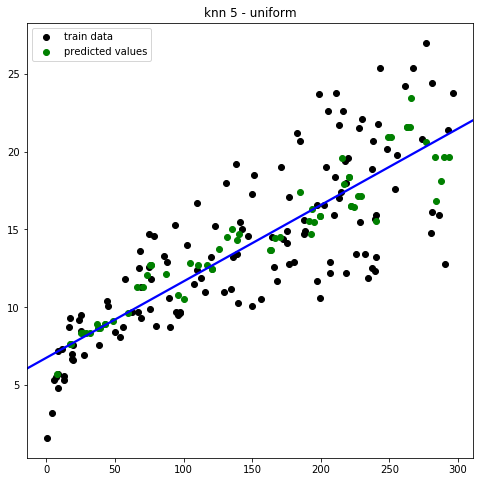

In [89]:
knn = KNeighborsRegressor(n_neighbors=5, weights="uniform")
plot_knn_regression(knn ,df, "knn 5 - uniform")

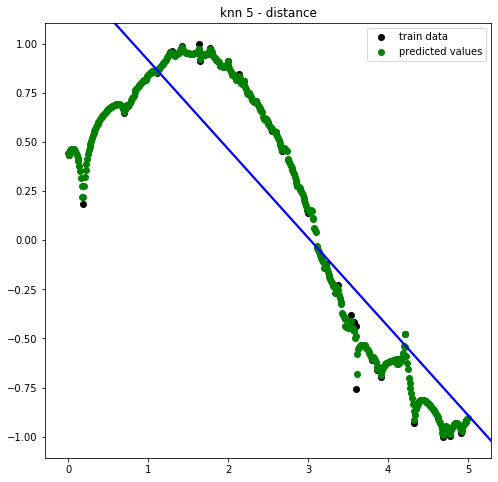

In [84]:
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel() #Return a contiguous flattened array.
# Add noise to targets
y[::5] += 1 * (0.5 - np.random.rand(8))

df_reduced = pd.DataFrame(X, columns=[""])
df_reduced.insert(len(df_reduced.columns), "target", y)

X_test = np.linspace(0, 5, 500)[:, np.newaxis]

knn = KNeighborsRegressor(n_neighbors=10, weights="distance")

plot_knn_regression(knn ,df_reduced, "knn 5 - distance", split=False, X_test=X_test)

# Linear Regression Plotter

In [ ]:
SEED = 46079990
import matplotlib.pyplot as plt
import seaborn as sns 

def plot_linear_regression(instance, df, title, split=True, X_test=None):
    from sklearn.model_selection import train_test_split
    
    if split:
        X_train, X_test, y_train, y_test = train_test_split(df.values[:,:-1], df.values[:,-1], test_size=0.33, random_state=SEED)
    else:
        X_train = df.values[:,:-1]
        y_train = df.values[:,-1]
        
    y_pred = instance.fit(X_train, y_train).predict(X_test)
    # Plots
    plt.figure(figsize=(8,8))
    #
    plt.scatter(X_train, y_train, c='k', label='train data')
    #
    plt.scatter(X_test, y_pred, c='g', label='predicted values')
    #plt.plot(T, y_knn_uniform, c='g', linewidth=1)
    #
    plt.axis('tight')
    plt.legend()
    plt.title(title);
    sns.regplot(X_train, y_train, order=1, ci=None, scatter=False, label='Linear', color='b')